In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn import utils
import plot_utils as pu
import matplotlib.pyplot as plt
import seaborn  as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import utils_daniel
utils_daniel.test_function()



Funker


Reading files and setting time and date forecasted as indexes

In [3]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')
X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_a = X_train_estimated_a.set_index("date_forecast")
X_train_estimated_b = X_train_estimated_b.set_index("date_forecast")
X_train_estimated_c = X_train_estimated_c.set_index("date_forecast")


X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')
X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_a = X_train_observed_a.set_index("date_forecast")
X_train_observed_b = X_train_observed_b.set_index("date_forecast")
X_train_observed_c = X_train_observed_c.set_index("date_forecast")

X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')
X_test_estimated_a['date_forecast'] = pd.to_datetime(X_test_estimated_a['date_forecast'])
X_test_estimated_b['date_forecast'] = pd.to_datetime(X_test_estimated_b['date_forecast'])
X_test_estimated_c['date_forecast'] = pd.to_datetime(X_test_estimated_c['date_forecast'])
X_test_estimated_a = X_test_estimated_a.set_index("date_forecast")
X_test_estimated_b = X_test_estimated_b.set_index("date_forecast")
X_test_estimated_c = X_test_estimated_c.set_index("date_forecast")

A_targets = pd.read_parquet("../data/A/train_targets.parquet")
B_targets = pd.read_parquet("../data/B/train_targets.parquet")
C_targets = pd.read_parquet("../data/C/train_targets.parquet")

A_targets["time"] = pd.to_datetime(A_targets["time"])
B_targets["time"] = pd.to_datetime(B_targets["time"])
C_targets["time"] = pd.to_datetime(C_targets["time"])
display(A_targets["time"].dtype)

A_targets = A_targets.set_index("time")
B_targets = B_targets.set_index("time")
C_targets = C_targets.set_index("time")




dtype('<M8[ns]')

Some plotting

IndexError: index 0 is out of bounds for axis 0 with size 0

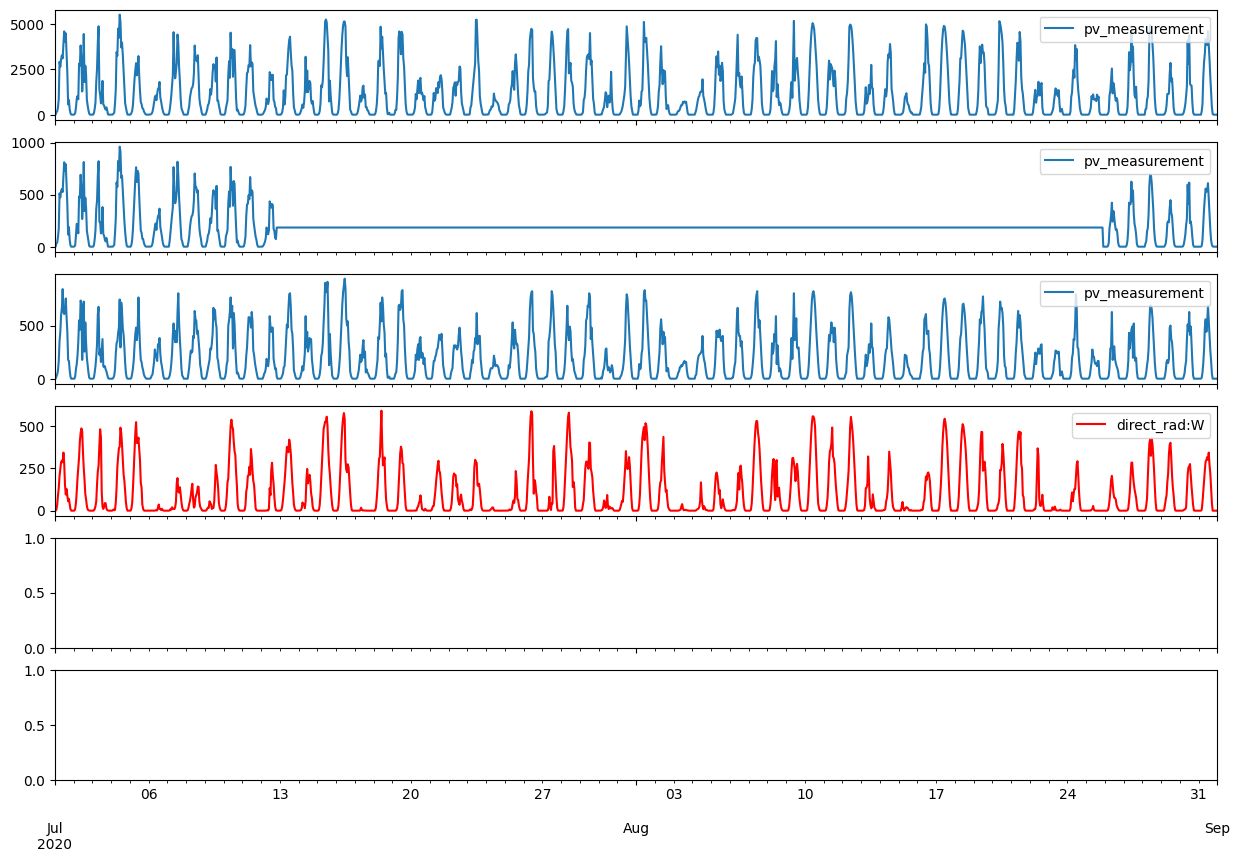

In [4]:
# generalized plotting
start_date = 'Jul 2020'
end_date = 'Sept 2020'

feature_name = "direct_rad:W"

Y = [A_targets, B_targets, C_targets]
X = [X_train_observed_a, X_test_estimated_a, X_train_observed_c, ]
     # X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, 
     # X_test_estimated_a, X_test_estimated_b, X_test_estimated_c]

utils_daniel.plot_ts(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)



Preprocessing

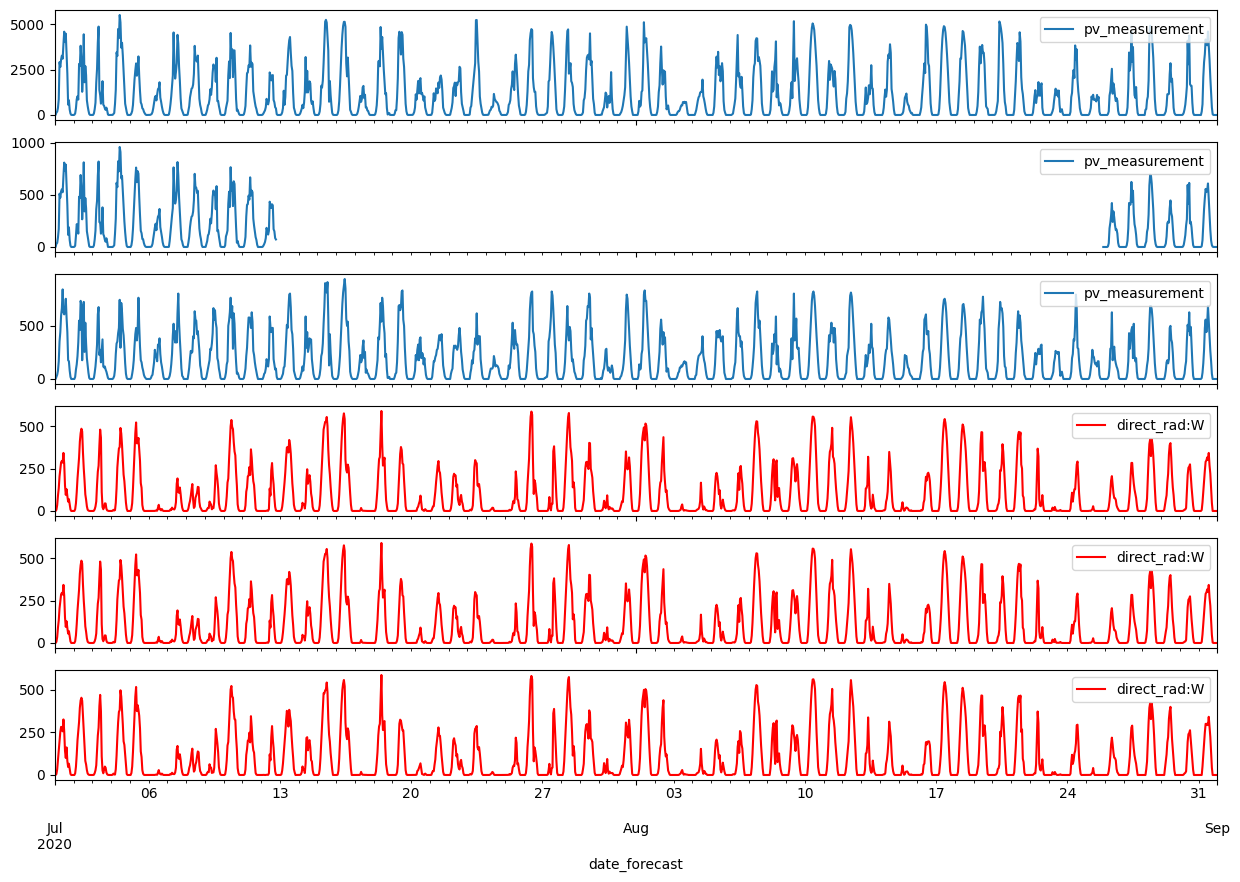

In [5]:
# removing rows where pv_measurment remains the same for more than 18 hours.
A_targets_clean = utils_daniel.remove_constant_values(A_targets, "pv_measurement", 18).dropna()
B_targets_clean = utils_daniel.remove_constant_values(B_targets, "pv_measurement", 18).dropna()
C_targets_clean = utils_daniel.remove_constant_values(C_targets, "pv_measurement", 18).dropna()

Y = [A_targets_clean, B_targets_clean, C_targets_clean]
X = [X_train_observed_a, X_train_observed_b, X_train_observed_c, ]
     # X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, 
     # X_test_estimated_a, X_test_estimated_b, X_test_estimated_c]

start_date = 'Jul 2020'
end_date = 'Sept 2020'

utils_daniel.plot_ts(y=Y, 
              x=X, 
              feature=feature_name, 
              start=start_date, 
              end=end_date, 
              shareX=True)

In [8]:
#not sure if this is necessary
# add hour and dayofyear as features to the datasets
X_train_observed_a_copy = utils_daniel.create_features(X_train_observed_a)
X_train_observed_b_copy = utils_daniel.create_features(X_train_observed_b)
X_train_observed_c_copy = utils_daniel.create_features(X_train_observed_c)

# Join the y values into x-dataframes for training
train_a = pd.merge(X_train_observed_a, A_targets_clean, left_index=True, right_index=True)
train_b = pd.merge(X_train_observed_b, B_targets_clean, left_index=True, right_index=True)
train_c = pd.merge(X_train_observed_c, C_targets_clean, left_index=True, right_index=True)
display(train_a)

print(train_a.shape)


#Split up the data again
FEATURES = train_a.columns[1:-1]

TARGETS = "pv_measurement"

### DATA
X_a = train_a[FEATURES]
y_a = train_a[TARGETS]
X_b = train_b[FEATURES]
y_b = train_b[TARGETS]
X_c = train_c[FEATURES]
y_c = train_c[TARGETS]
#display(X_a)
#display(y_a)
print(X_a.shape)
print(y_a.shape)
#print(y_a[:1])

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
2019-06-02 22:00:00,7.7,1.230,1744.900024,0.000000,0.0,1744.900024,0.0,280.299988,0.0,0.000000,...,-3.202000,0.0,285.899994,100.000000,39640.101562,3.7,-3.6,-0.8,-0.0,0.00
2019-06-02 23:00:00,7.7,1.225,1703.599976,0.000000,0.0,1703.599976,0.0,280.299988,0.0,0.000000,...,-4.393000,0.0,286.799988,100.000000,41699.898438,3.5,-3.5,0.0,-0.0,0.00
2019-06-03 00:00:00,7.7,1.221,1668.099976,0.000000,0.0,1668.099976,0.0,280.200012,0.0,0.000000,...,-3.910000,0.0,287.000000,100.000000,20473.000000,3.2,-3.1,0.7,-0.0,0.00
2019-06-03 01:00:00,8.2,1.218,1388.400024,0.000000,0.0,1388.400024,0.0,281.299988,0.0,0.000000,...,-1.986000,0.0,286.899994,100.000000,2104.600098,2.8,-2.7,0.8,-0.0,0.00
2019-06-03 02:00:00,8.8,1.219,1108.500000,6546.899902,9.8,1108.500000,0.0,282.299988,4.3,7743.299805,...,1.401000,0.0,286.500000,100.000000,2681.600098,2.7,-2.5,1.0,-0.0,19.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20 20:00:00,5.9,1.279,1291.500000,0.000000,0.0,1302.500000,0.0,276.000000,0.0,0.000000,...,-27.830000,0.0,278.399994,59.400002,41022.398438,2.0,0.6,1.9,-0.0,0.00
2022-10-20 21:00:00,5.7,1.283,NaN,0.000000,0.0,1009.299988,0.0,275.500000,0.0,0.000000,...,-32.546001,0.0,278.000000,23.799999,38581.898438,1.8,0.3,1.8,-0.0,0.00
2022-10-20 22:00:00,5.4,1.286,NaN,0.000000,0.0,149.500000,0.0,274.700012,0.0,0.000000,...,-35.674000,0.0,277.600006,12.200000,39697.699219,1.5,0.1,1.5,-0.0,0.00
2022-10-20 23:00:00,5.3,1.289,NaN,0.000000,0.0,NaN,0.0,274.399994,0.0,0.000000,...,-36.821999,0.0,277.299988,5.500000,28090.099609,1.3,-0.0,1.3,-0.0,0.00


(27741, 46)
(27741, 44)
(27741,)


Location A

In [15]:
#split data into training, validation and test
X_train, X_test, Y_train, Y_test = train_test_split(X_a, y_a, test_size=0.2, random_state=42)
#X_train_reshaped = X_train.values.reshape(X_train.shape[0], 24, 44)

print(X_train.shape)
print(Y_train.shape)

# Define LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, activation='relu'))
    model.add(Dense(1))  # Output layer with 1 neuron for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Assuming input_shape is (sequence_length, num_features)
input_shape = (1, 24 ,44)

# Create and train LSTM model for Region A
model_a = create_lstm_model(input_shape)
model_a.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))



# Predict solar power for the test set
predictions_a = model_a.predict(X_test_estimated_a)



predictions_a.plot()




(22192, 44) <class 'pandas.core.frame.DataFrame'>
(22192,)


ValueError: Input 0 of layer "lstm_7" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 1, 24, 44)